#Evaluate Channels PSG-Audio

Forked from Evaluate_Model_PSG-Audio.ipynb 1/31/2023 because there is a fair amount of additional data manipulation required for a standard model.  Goal is to generate a listing of how well each channel does relative to the others - it is not a absolute measure of channel performance.

As with the original this notebook implements groupKfold on the training set and does not utilize the test set at all to avoid leakage during model evaluation and tuning.

This is intended to be an interactive Jupyter notebook and not a stand alone .py file as with some of the other load_data code.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* This is very much an early version.
* Option to download from Zenodo removed.  Should put back in at some point.
* The cardio balancing has to be changed based on the input, should be calculated instead.
* Confusion matrix size needs to be adjusted and should also be converted to a figure to allow for saving to file.

# Imports

In [1]:
import os
import shutil
import time
from datetime import datetime
from datetime import date
from datetime import timedelta # for calculating training time
from random import randrange # for plotting samples
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tabulate import tabulate # for verbose tables, showing data
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder
import sys
import urllib.request # to get files from web w/o !wget
from shutil import unpack_archive # to unzip

In [2]:
my_dir = '.' # replace with absolute path if desired
interactive = True # runs simple calls for most cells
verbose = True

working_dir = os.path.join(my_dir,'psg_dataset') # create local directory
if not os.path.exists(working_dir):
    os.mkdir(working_dir)

# Get small or full processed PSG-Audio numpy arrays
See PSG-Audio_load_dataset_for_multi-output.ipynb for info, this is source of the arrays.


# Copy files from google drive (instead of Zenodo - much faster, less portable)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the processed dataset (small = every tenth sample, or full)

In [5]:
dataset_dir = '/content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_12ch_90_10_3s_3s'
use_small = True # arrays are 1/10th the size for shorter download/train time
if use_small:
    version = "small"
    flist = ["small_x_train.npy", "small_y_train.npy", "small_sub_train.npy"]
else:
    version = "full"
    flist = ["x_train.npy", "y_train.npy", "sub_train.npy"]

for fname in flist:
        print(fname, end=' ')
        if (os.path.exists(os.path.join(working_dir, fname))):
            if verbose:
                print ("Local",fname,"found, skipping download")
        else:
            print("copying")
            shutil.copy(os.path.join(dataset_dir, fname), working_dir)

small_x_train.npy copying
small_y_train.npy copying
small_sub_train.npy copying


In [21]:
def read_arrays():
    """read in the arrays - leaving test arrays out of this for now (just tuning model)"""
    if use_small:
        print("Reading in small arrays")
        X = np.load(os.path.join(working_dir, 'small_x_train.npy'))
        y = np.load(os.path.join(working_dir, 'small_y_train.npy'))
        sub = np.load(os.path.join(working_dir, 'small_sub_train.npy'))
    else:
        print("Reading in full arrays")
        X = np.load(os.path.join(working_dir, 'x_train.npy'))
        y = np.load(os.path.join(working_dir, 'y_train.npy'))
        sub = np.load(os.path.join(working_dir, 'sub_train.npy'))
    if verbose:
        headers = ("Array","original shape", "data type")
        mydata = [("X:", X.shape, X.dtype),
                ("y:", y.shape, y.dtype),
                ("sub:", sub.shape, sub.dtype)]
        print("\n",tabulate(mydata, headers=headers))
    return X, y, sub
if interactive:
    X, y, sub = read_arrays()

Reading in small arrays


# Load the model

In [7]:
model_dir = '/content/drive/MyDrive/Colab Notebooks/imics_lab_repositories/multi-output-psg/models'
model_fname = 'model_1d_cnn_dense.py'
#model_fname = 'model_1d_cnn_globavgpool.py'

shutil.copy(os.path.join(model_dir, model_fname), my_dir)

import model_1d_cnn_dense as my_model
#import model_1d_cnn_globavgpool as my_model

print ("Current model",my_model.description)

Current model 1D_CNN_Dense.py Concat input, 1D CNNs, with Dense Layers


# Define the functions to run experiment

In [23]:
def process_inputs(label, ch_group):
    """reads the X,y,sub arrays from files and modifies them by returning
    only the ch_group X channels, and the label for either cardiac or
    respiratory events.   Cardiac will be balanced, respiratory will be 
    collaped to normal and abnormal with both apnea and hyponea"""
    X, y, sub = read_arrays() # start fresh

    if label == 'Cardiac':
        y = y[:,0] # cardiac labels only
        #class_names = ['Normal','Bradycardia','Tachycardia','Long RR','Ptt Drop']
        class_names = ['Normal','Abnormal'] # matches _90_10 processed files

        # need to drop more normal in order to balance just Cardiac category.
        # this code leveraged from multi output load_data pseudo_balance_ir2
        # needs to be updated and put into generic function
        to_keep = 10 # 6 for 1s
        to_keep = 8 # for 5 sec
        to_keep = 7 # for 3 sec
        if verbose:
            print("dropping all but every",to_keep,"normal cardiac instance")
        idx = []
        for i in range(y.shape[0]):
            if (y[i] == 0) and (i%to_keep == 0):  # set mod based on imbalance
                idx.append(True) # keep normal based on to_keep (e.g. every 3rd instance)
            elif (y[i] >= 1):
                idx.append(True) # keep all abnormal
            else:
                idx.append(False) # drop other normals
        X = X[idx]
        y = y[idx]
        sub = sub[idx]

    if label == 'Respiratory':
        y = y[:,1] # respiratory labels only
        # the strange unk is for when there is mismatch error - need to understand better
        #class_names = ['Normal','Obstruct. Apnea', 'Central Apnea', 'Mixed Apena','Hypopnea','unk']
        class_names = ['Normal','Apnea', 'Hypopnea'] # original matches _90_10 processed files
        
        # collapsing Apnea and Hyponea to abnormal.
        idx = np.where(y[:] == 2) # find index of all 2 values
        y[idx] = 1 # set them to 1, so hyponea is now a version of abnormal
        unique, counts = np.unique(y[:], return_counts=True)
        if verbose:
            print("\ny label values and counts:\n",str(np.asarray((unique, counts)).T))
        class_names = ['Normal','Apnea+Hypopnea'] # matches _90_10 processed files


    y = y[np.newaxis].T # convert from (instances,) to (instances,1)

    #Channels in X: ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I', 'Flow Patient', 'Effort THO', 'Effort ABD']
    if (ch_group == 'EEG'):
        X = X[:,:,0:3] # first 3 channels (0,1,2)
    elif (ch_group == 'EOG'):
        X = X[:,:,3:5] # channels 3 and 4
    elif (ch_group == 'EMG'):
        X = X[:,:,5:6] # just channel 5
    elif (ch_group == 'ECG'):
        X = X[:,:,8:9] # ECG - this is a goofy way to keep shape w/ one channel...
    elif (ch_group == 'Flow'):
        X = X[:,:,9:10] # ECG - this is a goofy way to keep shape w/ one channel...
    elif (ch_group == 'Resp Effort'):
        X = X[:,:,10:12] # abd, thor
    elif (ch_group == 'Flow+Abd+Thor'):
        X = X[:,:,9:12] # flow, abd, thor
    elif (ch_group == 'ECG+Flow+Abd+Thor'):
        X = X[:,:,8:12] # ecg, flow, abd, thor
    else:
        print("No specific ch_group defined, using all channels")
    if verbose:
        print("Predicting", label, "using", ch_group)
        headers = ("Array"," processed shape", "data type")
        mydata = [("X:", X.shape, X.dtype),
                ("y:", y.shape, y.dtype),
                ("sub:", sub.shape, sub.dtype)]
        print("\n",tabulate(mydata, headers=headers))
        unique, counts = np.unique(y[:,0], return_counts=True)
        print("\ny label values and counts:\n",str(np.asarray((unique, counts)).T))
    return X, y, sub

In [22]:
# quick check to dial in keep_value
_,_,_ = process_inputs(label='Cardiac', ch_group = 'All')

Reading in small arrays
dropping all but every 7 normal cardiac instance
No specific ch_group defined, using all channels


In [24]:
def run_cross_val(X,y,sub,show_loss_plot = True, show_fold_detail = True):
    """runs a five fold cross-validation pass. returns accuracy string"""
    print ("running model",my_model.description)
    #print("Predicting", labels, "using", ch_group)


    # Define per-fold score containers
    acc_per_fold = []
    loss_per_fold = []
    y_pred_per_fold = []
    y_test_per_fold = []

    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    start_time = time.time()

    for i, (train_index, test_index) in enumerate(skf.split(X, y, groups=sub)):
        print(f"Fold {i}:", end='')

        x_train, y_train = X[train_index], y[train_index]
        x_test, y_test = X[test_index], y[test_index]
        
        # One Hot Encode: Note for respiratory there are 5 relatively frequent
        # categories but others can appear in only a portion of the folds.

        enc = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
        y_train = enc.fit_transform(y_train)
        y_test = enc.transform(y_test)

        model = my_model.build_model(x_train, y_train)
        history, model = my_model.train_model(model, x_train, y_train,
                                            x_test, y_test)  
        val_acc = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1] 

        acc_per_fold.append(val_acc * 100)
        loss_per_fold.append(val_loss)

        # Generate predictions
        y_pred = model.predict(x_test, verbose = 0)

        y_pred = np.argmax(y_pred, axis=1)
        y_pred_per_fold.append(y_pred)
        y_test_per_fold.append(np.argmax(y_test, axis=1))

        # Plot training & validation loss values
        if show_loss_plot:
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('Model loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Test'], loc='upper left')
            plt.show()

    # == Provide average scores ==
    if (show_fold_detail):
        print('------------------------------------------------------------------------')
        print('Score per fold')
        for i in range(0, len(acc_per_fold)):
        #     print('------------------------------------------------------------------------')
            print(f'> Fold {i+1} - Loss: {loss_per_fold[i]:4.2} - Accuracy: {acc_per_fold[i]:4.2f}%')
        print('------------------------------------------------------------------------')
        print('Average scores for all folds:')
        print(f'> Accuracy: {np.mean(acc_per_fold):4.2f} (+- {np.std(acc_per_fold):5.4})')
        print('------------------------------------------------------------------------')
    acc_str = temp = str(f'> Accuracy: {np.mean(acc_per_fold):4.2f} (+- {np.std(acc_per_fold):5.4})')
    # Show total training time
    end_time = time.time()
    train_time = timedelta(seconds=(end_time - start_time))
    print('Total Training time =',(str(train_time).split(".")[0]), 'HH:MM:SS')
    # to plot confusion matrices return concat versions of y
    y_pred = np.concatenate(y_pred_per_fold)
    y_test = np.concatenate(y_test_per_fold)
    return acc_str, y_pred, y_test
# result, y_pred, y_test = run_cross_val()
# print ("running model",my_model.description)
# print("Predicting", labels, "using", ch_group)
# print(result)

# Run Experiment

In [ ]:
# my_model.MAX_EPOCHS = 6 # just for testing

In [25]:
verbose = False # output from this notebook
my_model.lrn_verbose = False # turn off model output
label_list = ['Cardiac','Respiratory']
ch_grp_list = ['EEG','EOG','EMG','ECG','Flow','Resp Effort', 'All']

for label in label_list:
    print("Processing",label,"channels: ")
    for ch_group in ch_grp_list:
        
        X, y, sub = process_inputs(label=label, ch_group=ch_group)
        result, y_pred, y_test = run_cross_val(X,y,sub,show_loss_plot=False,show_fold_detail = False)
        print(ch_group, result)
    print()
print()


Processing Cardiac channels: 
Reading in small arrays
running model 1D_CNN_Dense.py Concat input, 1D CNNs, with Dense Layers
Fold 0:Fold 1:Fold 2:Fold 3:Fold 4:Total Training time = 0:02:13 HH:MM:SS
EEG > Accuracy: 43.20 (+-  3.99)
Reading in small arrays
running model 1D_CNN_Dense.py Concat input, 1D CNNs, with Dense Layers
Fold 0:Fold 1:Fold 2:Fold 3:Fold 4:Total Training time = 0:02:38 HH:MM:SS
EOG > Accuracy: 64.62 (+- 2.714)
Reading in small arrays
running model 1D_CNN_Dense.py Concat input, 1D CNNs, with Dense Layers
Fold 0:Fold 1:Fold 2:Fold 3:Fold 4:Total Training time = 0:02:15 HH:MM:SS
EMG > Accuracy: 44.83 (+- 7.718)
Reading in small arrays
running model 1D_CNN_Dense.py Concat input, 1D CNNs, with Dense Layers
Fold 0:Fold 1:Fold 2:Fold 3:Fold 4:Total Training time = 0:03:04 HH:MM:SS
ECG > Accuracy: 60.07 (+- 2.092)
Reading in small arrays
running model 1D_CNN_Dense.py Concat input, 1D CNNs, with Dense Layers
Fold 0:Fold 1:Fold 2:Fold 3:Fold 4:Total Training time = 0:01:46 HH

In [ ]:
#my_model.MAX_EPOCHS = 6 # just to test the code

                precision    recall  f1-score   support

        Normal       0.88      0.71      0.79     23252
Apnea+Hypopnea       0.72      0.88      0.79     19081

      accuracy                           0.79     42333
     macro avg       0.80      0.80      0.79     42333
  weighted avg       0.81      0.79      0.79     42333

Normalized confusion matrix
[[0.71 0.29]
 [0.12 0.88]]


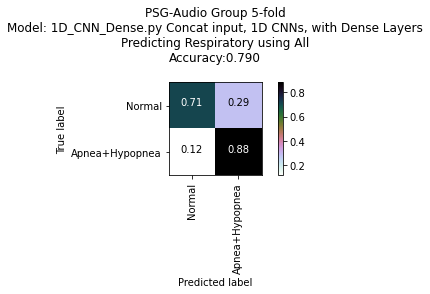

In [29]:
# this needs to be setup as a global or passed back from process_inputs()
class_names = ['Normal','Apnea+Hypopnea'] # matches _90_10 processed files

# == Confusion matrix ==
from sklearn.metrics import confusion_matrix
import itertools

#moved to evaluate function
#y_pred = np.concatenate(y_pred_per_fold)
#y_test = np.concatenate(y_test_per_fold)

print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                            normalize=True,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
            print(np.array(cm).round(2)) # to limit digits
        else:
            print('Confusion matrix, without normalization')
            print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes,rotation=90)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
title = 'PSG-Audio Group 5-fold\n'
title +=  "Model: " + my_model.description + '\n'
title += "Predicting " + label + " using " + ch_group + '\n'
title += 'Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred))+'\n'
plot_confusion_matrix(cm, classes=class_names, title=title, cmap='cubehelix_r')

# STOP - the following code is to load the data from and save figures to google drive.
You are welcome to use it, but it is untested outside of my environment.

In [30]:
def get_load_data_utils():
    """checks for local file, if none downloads from IMICS repository.
    Assumes a global my_dir has been defined (default is my_dir = ".")
    :return: nothing"""
    fname = 'load_data_utils.py'
    ffname = os.path.join(my_dir,fname)
    if (os.path.exists(ffname)):
        if verbose:
            print ("Local load_data_utils.py found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve("https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py", filename=fname)
if interactive:
    get_load_data_utils()

In [31]:
from load_data_utils import get_env_info
from load_data_utils import get_log_ffname
from load_data_utils import tabulate_numpy_arrays
from load_data_utils import channel_powerset
if interactive:
    print('My env_info: \n' + get_env_info())

My env_info: 
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
GPU: name, driver_version, memory.total [MiB]
Tesla T4, 510.47.03, 15360 MiB



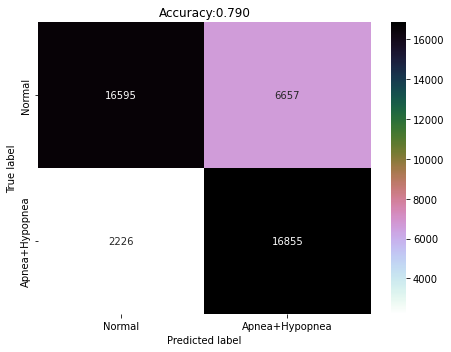

In [32]:
save_log = False # set to False to avoid a problem if accidentally run...
# alternate confusion matrix with fig object to save
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                    index = class_names, 
                    columns = class_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
#plt.title('Insert title here\n
#plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()
if save_log:
    log_ffname = get_log_ffname(
    log_file_dir = '/content/drive/My Drive/Colab_Run_Results',
    base_fname = "PSG_Multi_Output_Work")
    print("Saving results to", log_ffname)
    with open(log_ffname, "a") as file_object:
        file_object.write("Generated by Evaluate_Model_PSG-Audio.ipynb\n")
        file_object.write("Processed PSG with 5 fold via sklearn GroupKFold\n")
        file_object.write("Final Accuracy: %0.3f\n" %accuracy_score(y_test, y_pred))
        file_object.write("Classification Report\n")
        file_object.write(classification_report(y_test, y_pred, target_names=class_names))
        file_object.write("Confusion Matrix\n")
        file_object.write(str(cm))
    cm_ffname = log_ffname.split('.')[0] + '_cm.pdf'
    print("saving cm plot as",cm_ffname)
    fig.savefig(cm_ffname,format='pdf', dpi=1200)
    full_model_fname = log_ffname.split('.')[0] + '_model.txt'
    with open(full_model_fname, "a") as file_object:
        model.summary(print_fn=lambda x: file_object.write(x + '\n'))
        #acknowledgement https://stackoverflow.com/users/14951382/sparklingdew
    #plot using keras function
    #ref https://keras.io/api/utils/model_plotting_utils/
    full_mplot_fname = log_ffname.split('.')[0] + '_model.png'
    keras.utils.plot_model(model, to_file=full_mplot_fname, show_shapes=True)